# Imports and Load Data

In [27]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import joblib
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense

In [2]:
fpath = 'data/part1-aml-belt-exam.csv'
df = pd.read_csv(fpath)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551 entries, 0 to 3550
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  3551 non-null   object
 1   text    3551 non-null   object
dtypes: object(2)
memory usage: 55.6+ KB


,author,text
0,Poe,additional information either on Monday ...
1,Poe,teeth. Not a speck on their surface—not ...
2,Dickens,“Harry? As soon as he had seen your friend her...
3,Poe,thought—to make sure that my vision had ...
4,Poe,the flowers. No guile disguised the ferv...


# Preprocess Data

In [4]:
# Load spacy model with specific components
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])

def preprocess_text(doc):
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    return tokens, lemmas

# Create needed columns for preprocessing
df['processed'] = df['text'].apply(nlp)
df['tokens'], df['lemmas'] = zip(*df['processed'].apply(preprocess_text))
df['tokens_joined'] = df['tokens'].apply(' '.join)
df['lemmas_joined'] = df['lemmas'].apply(' '.join)

# Drop temp column 'processed'
df.drop(columns='processed', inplace=True)

df.head()

,author,text,tokens,lemmas,tokens_joined,lemmas_joined
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]",thought sure vision deceived calm,think sure vision deceive calm
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim...","[flower, guile, disguise, fervor, love, animate]",flowers guile disguised fervor love animated,flower guile disguise fervor love animate


## Creating a Word Cloud for Each Author

In [6]:
def gen_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [7]:
poe_raw = ' '.join(df[df['author'] == 'Poe']['text'])
dick_raw = ' '.join(df[df['author'] == 'Dickens']['text'])

poe_lemmas = ' '.join(df[df['author'] == 'Poe']['lemmas_joined'])
dick_lemmas = ' '.join(df[df['author'] == 'Dickens']['lemmas_joined'])

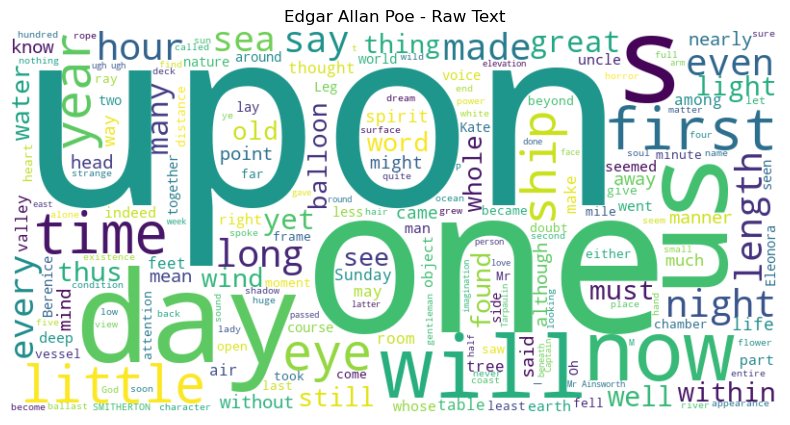

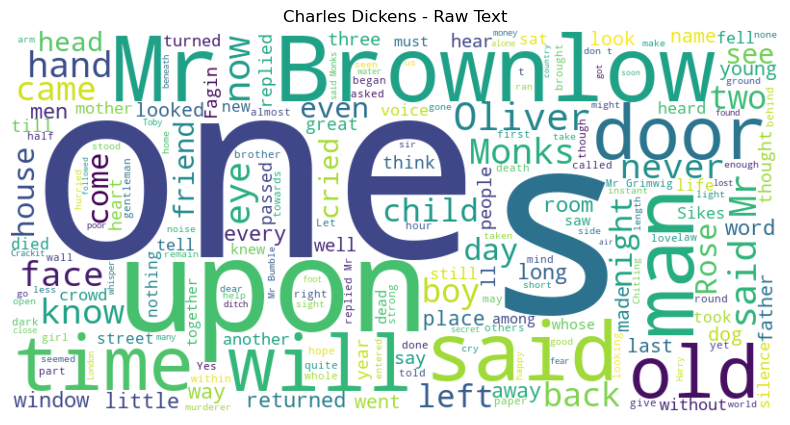

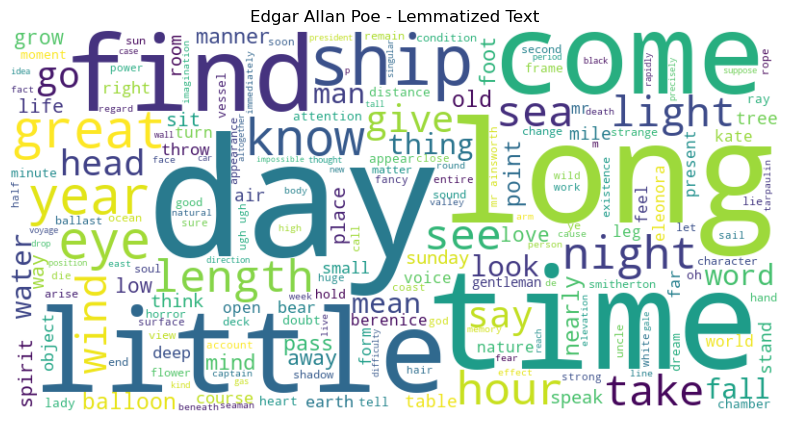

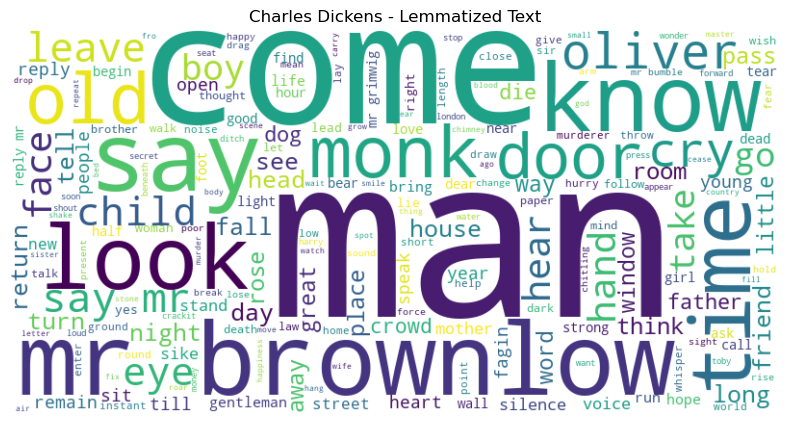

In [9]:
# Generate word clouds
gen_word_cloud(poe_raw, "Edgar Allan Poe - Raw Text")
gen_word_cloud(dick_raw, "Charles Dickens - Raw Text")

gen_word_cloud(poe_lemmas, "Edgar Allan Poe - Lemmatized Text")
gen_word_cloud(dick_lemmas, "Charles Dickens - Lemmatized Text")

## 20 Most Freq. Bigrams

In [11]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [12]:
# Combine the tokens back to text for vectorization
poe_text = df[df['author'] == 'Poe']['tokens_joined'].tolist()
dick_text = df[df['author'] == 'Dickens']['tokens_joined'].tolist()

In [14]:
# Get the top 20 bigrams
poe_bigrams = get_top_n_bigrams(poe_text, 20)
dick_bigrams = get_top_n_bigrams(dick_text, 20)

In [15]:
# Create DataFrames to display the bigrams
poe_bigrams_df = pd.DataFrame(poe_bigrams, columns=['Bigram', 'Frequency'])
dick_bigrams_df = pd.DataFrame(dick_bigrams, columns=['Bigram', 'Frequency'])

# Combine the DataFrames
bigrams_df = pd.concat([poe_bigrams_df.assign(Author='Poe'), dick_bigrams_df.assign(Author='Dickens')], axis=0)
bigrams_df

,Bigram,Frequency,Author
0,mr ainsworth,10,Poe
1,ugh ugh,10,Poe
2,thousand miles,8,Poe
3,valley colored,7,Poe
4,guide rope,7,Poe
5,colored grass,6,Poe
6,ha ha,6,Poe
7,mr rumgudgeon,5,Poe
8,000 feet,5,Poe
9,king pest,5,Poe


# Machine Learning - Text Classification

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['author'], test_size=0.3, random_state=321)

# Creating a pipeline with CountVectorizer and MultinomialNB
model_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

# Training the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [18]:
# Predicting and evaluating the model
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Dickens       0.78      0.84      0.81       422
         Poe       0.89      0.84      0.87       644

    accuracy                           0.84      1066
   macro avg       0.84      0.84      0.84      1066
weighted avg       0.85      0.84      0.84      1066



In [19]:
# Saving the model pipeline
joblib.dump(model_pipeline, 'models/multinomial_nb_pipeline.joblib')

['models/multinomial_nb_pipeline.joblib']

# Creating Deep NLP Model

In [21]:
# Encode the target variable
label_encoder = LabelEncoder()
df['author_encoded'] = label_encoder.fit_transform(df['author'])

In [22]:
# Find the appropriate sequence length (95th percentile)
seq_lengths = np.array([len(text.split()) for text in df['text']])
max_seq_length = int(np.percentile(seq_lengths, 95))

In [23]:
# TextVectorization layer to standardize, tokenize, and vectorize the data
vectorize_layer = TextVectorization(max_tokens=20000, output_sequence_length=max_seq_length)
vectorize_layer.adapt(df['text'].to_numpy())

In [24]:
# Prepare the TensorFlow dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((df['text'].to_numpy(), df['author_encoded'].to_numpy()))
tf_dataset = tf_dataset.batch(32)

In [25]:
# Splitting the dataset into train, validation, and test sets
train_size = int(len(tf_dataset) * 0.7)
val_size = int(len(tf_dataset) * 0.15)
test_size = int(len(tf_dataset) * 0.15)

In [26]:
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [31]:
# After adapting the vectorize_layer
vocab_size = len(vectorize_layer.get_vocabulary())
max_tokens = vocab_size

# Building the model
model = Sequential([
    vectorize_layer,
    Embedding(max_tokens + 1, 100),
    Bidirectional(GRU(128, return_sequences=True)),
    Bidirectional(GRU(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=5)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/5
77/77 [==============================] - 7s 28ms/step - loss: 0.5183 - accuracy: 0.7342 - val_loss: 0.3985 - val_accuracy: 0.8400
Epoch 2/5
77/77 [==============================] - 1s 16ms/step - loss: 0.1653 - accuracy: 0.9367 - val_loss: 0.4175 - val_accuracy: 0.8470
Epoch 3/5
77/77 [==============================] - 1s 16ms/step - loss: 0.0470 - accuracy: 0.9850 - val_loss: 0.5852 - val_accuracy: 0.8348
Epoch 4/5
77/77 [==============================] - 1s 16ms/step - loss: 0.0110 - accuracy: 0.9955 - val_loss: 0.7737 - val_accuracy: 0.8417
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 1.1655 - accuracy: 0.7969
Test Loss: 1.1655187606811523
Test Accuracy: 0.796875


In [32]:
model.save('Models/author_classification_model', save_format='tf')

INFO:tensorflow:Assets written to: Models/author_classification_model\assets


INFO:tensorflow:Assets written to: Models/author_classification_model\assets
